In [1]:
using Gync, JLD, Mamba
using ColorBrewer

# compute the acceptance rate of each markov chain
acceptance(mc::Array) = mapslices(mc,[1,2]) do mc
    n = size(mc,1)
    sum([mc[i,:,:] != mc[i+1,:,:] for i in 1:n-1]) / (n-1);
  end |> vec

acceptance(c::AbstractChains) = acceptance(c.value)

mergeparms!(aparms, sparms) = (aparms[SAMPLEPARMS]=sparms; aparms)

mergeparms(aparms, sparms) = mergeparms!(copy(aparms), sparms)

function loglikelihood(mc::Array{Float64,3}, data::Matrix)
    mapslices(mc, 2) do modelparms
        aparms = mergeparms(parms, modelparms[1:length(SAMPLEPARMS)])
        y0 = modelparms[length(SAMPLEPARMS)+1:end]
        loglikelihood(data, aparms, y0)
    end
end

mergepersons(mcs) = 
    cat(3,
        map(x->x[1:minimum(map(x->size(x,1), mcs)),:,:],
            mcs)...);

loglikelihood(mc::AbstractChains, data::Matrix) = loglikelihood(mc.value, data);

function newestjld()
    jlds = filter(x->endswith(x, "jld"), readdir("../out"))
    file = jlds[indmax(map(x->stat(x).mtime, jlds))]
end;

INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/JLD.ji for module JLD.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/HDF5.ji for module HDF5.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/MAT.ji for module MAT.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/Compose.ji for module Compose.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/Colors.ji for module Colors.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/DataStructures.ji for module DataStructures.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/Measures.ji for module Measures.
INFO: Recompiling stale cache file /home/numerik/bzfsikor/.julia/lib/v0.4/Graphics.ji for module Graphics.
INFO: Recompiling stale cache file /home/numerik/

In [116]:
thin = 1 # destroys acceptance

fac20err10 = ["../out/fac20err10/$(p)_$c.jld" for p in 1:3, c in 1:3]
fac5err5   = ["../out/fac5err5/$(p)_$c.jld"   for p in 1:3, c in 1:3]
fac5err10  = ["../out/fac5err10/$(p)_$c.jld"  for p in 1:3, c in 1:3]

files = fac5err10

commonlength = minimum(
    [jldopen(file->size(file["chains"],1), f, "r")
    for f in files])

mcs = Chains(cat(3, [load(f)["chains"][1:thin:commonlength, :, :] for f in files]...), 
names=[Gync.parameternames[Gync.sampleparms]; Gync.speciesnames])

println("size: ", size(mcs))
println("acc:  ", map(x->round(x,3),acceptance(mcs)))

size: (3000,115,9)
acc:  [0.994,0.988,0.998,0.994,0.998,0.998,0.993,0.985,0.998]


In [117]:
# print all sampled names
for (i,v) in enumerate(Gync.samplednames)
    print(i, " ",v)
end

1 basal LH synthesis rate constant
2 E2 promoted LH synthesis rate constant
3 threshold of E2
4 threshold of P4
5 basal LH release rate constant
6 infuence of GnRH receptor complex on LH release
7 threshold of GnRH on LH release rate
8 blood volume
9 binding rate of LH to its receptor
10 clearance rate of LH from the blood
11 formation rate of free LH receptors
12 desensitization rate of LH receptor complex
13 basal FSH synthesis rate constant
14 threshold of Inhibin A in FSH synthesis
15 threshold of Inhibin B in FSH synthesis
16 threshold of FSH (former GnRH?!) frequency
17 basal FSH release rate constant
18 stimulation of FSH release by GnRH receptor complex
19 threshold of GnRH on FSH release rate
20 binding rate of FSH to its receptor
21 clearance rate of FSH from the blood
22 formation rate of free FSH receptors
23 desensitization rate of FSH receptor complex
24 synthesis rate constant of LH receptors on granulosa cells
25 threshold of FSH-R to stimulate LH receptors on granulosa

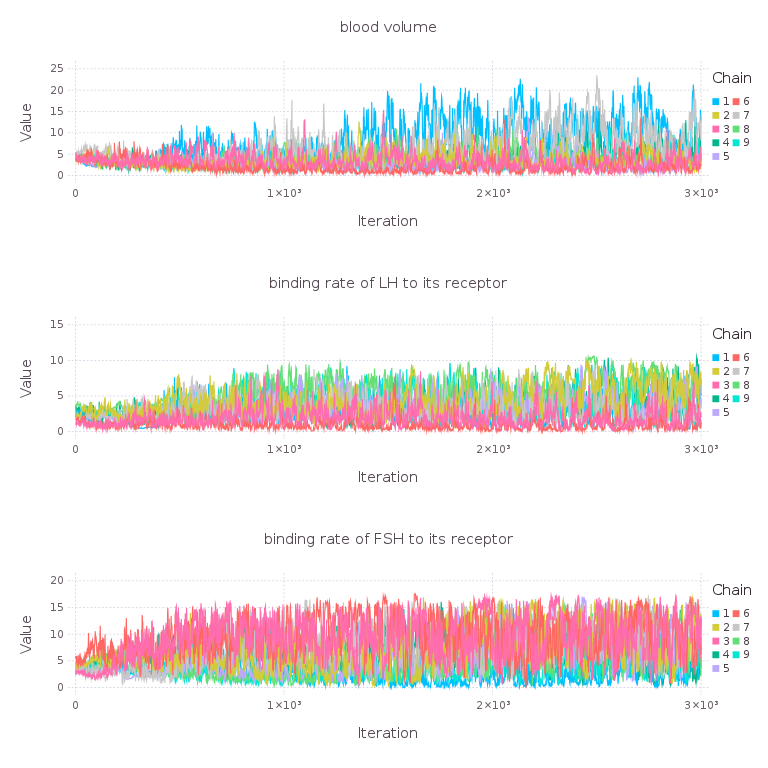

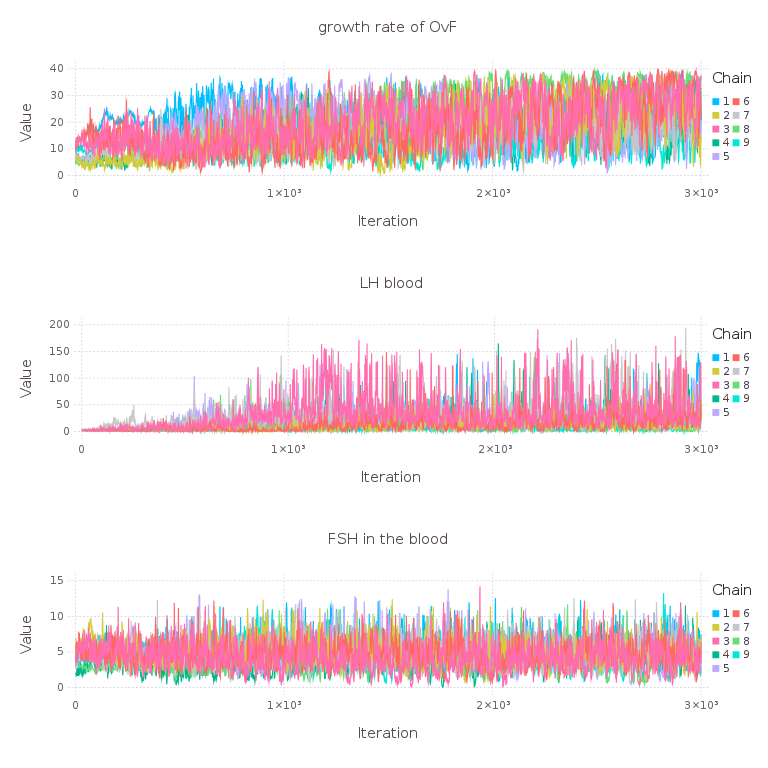

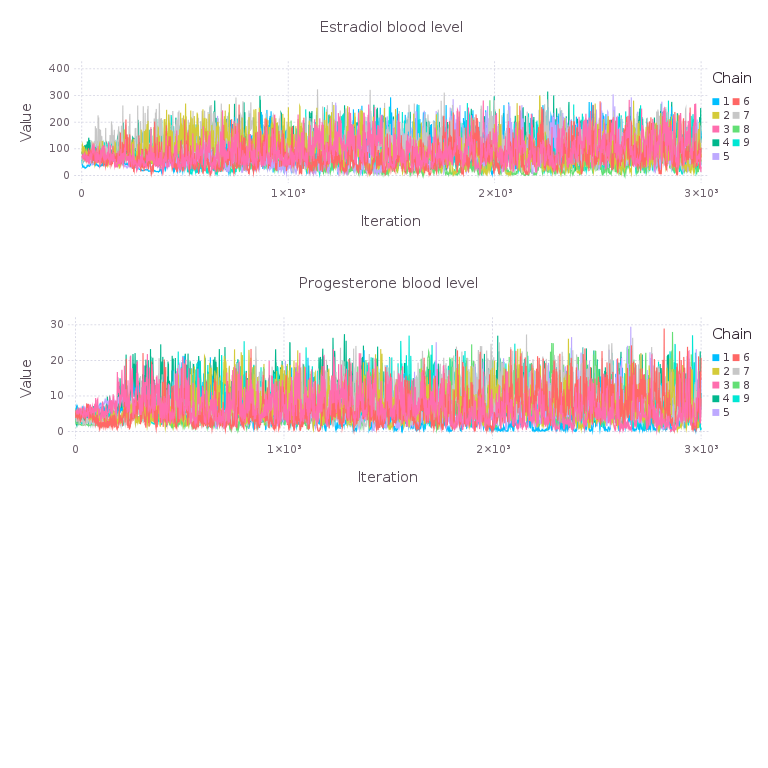

0.479322 seconds (4.41 M allocations: 126.888 MB, 6.76% gc time)
  4.822838 seconds (39.30 M allocations: 1.178 GB, 8.52% gc time)


In [118]:
plotspecies = [8, 9, 20, 39, 84, 89, 106, 107]
#plotspecies = Colon()
burnin = 0_000 / thin |> Int
types = [:trace, :autocor, :mean, :density]
#types = [:density]
types = [:trace]#, :autocor, :mean]
step = 1
@time plots = plot(mcs[burnin+1:step:end,plotspecies,:], types, trim=(0,1), legend=true)

@time draw(plots, ask=false, fmt=:png, ncol=length(types))

In [121]:
import Gync: sampledmles
using Gadfly: layer, Geom
using ColorBrewer

addmle!(plot::Gadfly.Plot, species::Int) = push!(plot, layer(Geom.vline, xintercept=[Gync.sampledmles[species]]))

function analyse(mcs)
    [analyse_single(mcs[:,i,:]) for i = 1:size(mcs,2)]
end

function analyse_single(mc)
    size(mc,2) == 1 || error("chain contains multiple variables")
    const plotresolution = 20_000
    
    step = max(round(Int, size(mc, 1) / plotresolution), 1)
    p = plot(mc[1:step:end,:,:], :density, trim=(0,1), legend=true, format=:PNG)[1]
    species = findnext(Gync.samplednames, mc.names[1],1)
    addmle!(p, species)
    
    colors = vcat(map(c->palette(c, 6)[3:5], ["GnBu", "Greys", "Oranges"])...)
    push!(p, Gadfly.Scale.discrete_color_manual(colors...))

    
    gelman = gelmandiag(mc[:,:,:])
    println("Gelman Rubin (PSRF, 97.5%): ", string(gelman.value))
    display(p)
    p
end

plots = analyse(mcs[burnin:step:end,plotspecies,:]);

Gelman Rubin (PSRF, 97.5%): [1.42 2.01]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 -50 
 0 
 50 
 100 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M45,78.71 L 45.14 78.71 45.29 78.71 45.44 78.71 45.59 78.71 45.74 78.71 45.89 78.71 46.04 78.7 46.19 78.69 46.34 78.67 46.49 78.65 46.64 78.6 46.79 78.53 46.94 78.43 47.09 78.28 47.24 78.08 47.39 77.81 47.54 77.47 47.69 77.04 47.84 76.51 47.99 75.89 48.14 75.15 48.28 74.32 48.43 73.38 48.58 72.34 48.73 71.22 48.88 70.03 49.03 68.8 49.18 67.54 49.33 66.26 49.48 65 49.63 63.76 49.78 62.55 49.93 61.39 50.08 60.29 50.23 59.26 50.38 58.31 50.53 57.45 50.68 56.69 50.83 56.03 50.98 55.46 51.13 54.97 51.28 54.54 51.43 54.13 51.57 53.69 51.72 53.21 51.87 52.64 52.02 51.98 52.17 51.21 52.32 50.35 52.47 49.43 52.62 48.49 52.77 47.56 52.92 46.69 53.07 45.93 53.22 45.32 53.37 44.87 53.52 44.62 53.67 44.55 53.82 44.65 53.97 44.9 54.12 45.26 54.27 45.68 54.42 46.12 54.57 46.55 54.71 46.93 54.86 47.24 55.01 47.5 55.16 47.69 55.31 47.86 55.46 48.01 55.61 48.2 55.76 48.44 55.91 48.76 56.06 49.18 56.21 49.71 56.36 50.35 56.51 51.1 56.66 51.95 56.81 52.88 56.96 53.88 57.11 54.93 57.26 56 57.41 57.09 57.56 58.16 57.71 59.2 57.86 60.18 58 61.08 58.15 61.89 58.3 62.62 58.45 63.27 58.6 63.84 58.75 64.36 58.9 64.85 59.05 65.32 59.2 65.79 59.35 66.25 59.5 66.71 59.65 67.15 59.8 67.58 59.95 67.97 60.1 68.33 60.25 68.66 60.4 68.95 60.55 69.21 60.7 69.45 60.85 69.67 61 69.88 61.14 70.09 61.29 70.29 61.44 70.5 61.59 70.7 61.74 70.91 61.89 71.13 62.04 71.35 62.19 71.57 62.34 71.79 62.49 72.01 62.64 72.23 62.79 72.44 62.94 72.64 63.09 72.84 63.24 73.03 63.39 73.22 63.54 73.4 63.69 73.58 63.84 73.75 63.99 73.92 64.14 74.08 64.29 74.23 64.43 74.38 64.58 74.53 64.73 74.68 64.88 74.84 65.03 75 65.18 75.17 65.33 75.34 65.48 75.51 65.63 75.68 65.78 75.84 65.93 76 66.08 76.15 66.23 76.28 66.38 76.41 66.53 76.53 66.68 76.63 66.83 76.73 66.98 76.82 67.13 76.89 67.28 76.96 67.43 77.03 67.57 77.08 67.72 77.14 67.87 77.19 68.02 77.24 68.17 77.29 68.32 77.34 68.47 77.39 68.62 77.45 68.77 77.5 68.92 77.55 69.07 77.6 69.22 77.66 69.37 77.71 69.52 77.76 69.67 77.82 69.82 77.87 69.97 77.93 70.12 77.98 70.27 78.03 70.42 78.08 70.57 78.12 70.72 78.16 70.86 78.2 71.01 78.22 71.16 78.25 71.31 78.27 71.46 78.28 71.61 78.3 71.76 78.31 71.91 78.32 72.06 78.34 72.21 78.35 72.36 78.36 72.51 78.38 72.66 78.39 72.81 78.4 72.96 78.41 73.11 78.41 73.26 78.42 73.41 78.42 73.56 78.42 73.71 78.43 73.86 78.43 74 78.44 74.15 78.45 74.3 78.47 74.45 78.49 74.6 78.51 74.75 78.53 74.9 78.55 75.05 78.57 75.2 78.59 75.35 78.6 75.5 78.61 75.65 78.62 75.8 78.62 75.95 78.62 76.1 78.62 76.25 78.62 76.4 78.62 76.55 78.62 76.7 78.61 76.85 78.6 77 78.59 77.15 78.58 77.29 78.56 77.44 78.54 77.59 78.52 77.74 78.5 77.89 78.48 78.04 78.47 78.19 78.46 78.34 78.46 78.49 78.47 78.64 78.49 78.79 78.52 78.94 78.54 79.09 78.57 79.24 78.59 79.39 78.61 79.54 78.62 79.69 78.62 79.84 78.61 79.99 78.6 80.14 78.59 80.29 78.57 80.43 78.

LoadError: LoadError: MethodError: `convert` has no method matching convert(::Type{Compose.Image{Compose.PNGBackend}})
This may have arisen from a call to the constructor Compose.Image{Compose.PNGBackend}(...),
since type constructors fall back to convert methods.
Closest candidates are:
  convert{T}(::Type{T}, !Matched::T)
  Compose.Image{B<:Compose.ImageBackend}(, !Matched::Cairo.CairoSurface, !Matched::Cairo.CairoContext, !Matched::IO)
  Compose.Image{B<:Compose.ImageBackend}(, !Matched::Cairo.CairoSurface, !Matched::Cairo.CairoContext)
  ...
while loading In[121], in expression starting on line 31

In [110]:
rafterydiag = Mamba.rafterydiag(mcs[:,plotspecies,:])

ErrorException: At least one finite value must be provided to formatter.

In [ ]:
x=gelmandiag(mcs[:,:,:])
notc = x.value[:,2].>1.2
[find(notc) x.value[notc,2]]

In [ ]:
parms, y0 = loadparms()
SIGMA_RHO = 0.2
SIGMA_Y0  = 1
SIGMA_PARMS = 20
SIGMA_PROPOSAL = 0.1
l=loglikelihood(mcs[1:5000:end,:,:], loadpfizer()[1])

In [ ]:
map(i -> mean(l[2:end,:,i]), 1:5)